<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

<hr>

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement network topology

I use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

I simplify the implementation of this lab by padding the feature maps as they pass through each convolution, making the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper. 


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
import matplotlib.image as mpimg
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [2]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [3]:
class ConvSection(nn.Module):
  def __init__(self, in_channels, out_channels, up_sample=False):
    super(ConvSection, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, (3,3), padding=(1,1))
    self.conv2 = nn.Conv2d(out_channels, out_channels, (3,3), padding=(1,1))
    self.up_sample = up_sample
    if up_sample:
      self.up = nn.ConvTranspose2d(out_channels, out_channels//2, 2, stride=2)

  def forward(self, input):
    layer1 = F.relu(self.conv1(input))
    layer2 = F.relu(self.conv2(layer1))
    if self.up_sample:
      layer2 = self.up(layer2)
    return layer2


class CancerDetection(nn.Module):
  def __init__(self):
    super(CancerDetection, self).__init__()
    # Down Layers
    self.down_section1 = ConvSection(3, 64)
    self.down_section2 = ConvSection(64, 128)
    self.down_section3 = ConvSection(128, 256)
    self.down_section4 = ConvSection(256, 512)

    # MaxPool
    self.maxpool = nn.MaxPool2d((2,2), stride=2)

    # Bottom to Up Layers
    self.up_section1 = ConvSection(512, 1024, up_sample=True)
    self.up_section2 = ConvSection(1024, 512, up_sample=True)
    self.up_section3 = ConvSection(512, 256, up_sample=True)
    self.up_section4 = ConvSection(256, 128, up_sample=True)
    self.up_section5 = ConvSection(128, 64)

    # Final Layer
    self.final = nn.Conv2d(64, 2, (3,3), padding=(1,1))

  def forward(self, input):
    # Work down, calling maxpool for each convolutional section
    down_1_out = self.down_section1(input)
    max_pool_1 = self.maxpool(down_1_out)

    down_2_out = self.down_section2(max_pool_1)
    max_pool_2 = self.maxpool(down_2_out)

    down_3_out = self.down_section3(max_pool_2)
    max_pool_3 = self.maxpool(down_3_out)

    down_4_out = self.down_section4(max_pool_3)
    max_pool_4 = self.maxpool(down_4_out)

    # Work up
    up_1_out = self.up_section1(max_pool_4)
    
    concat_1 = torch.cat((down_4_out, up_1_out), dim=1)
    up_2_out = self.up_section2(concat_1)

    concat_2 = torch.cat((down_3_out, up_2_out), dim=1)
    up_3_out = self.up_section3(concat_2)

    concat_3 = torch.cat((down_2_out, up_3_out), dim=1)
    up_4_out = self.up_section4(concat_3)

    concat_4 = torch.cat((down_1_out, up_4_out), dim=1)
    final_block = self.up_section5(concat_4)
    final = self.final(final_block)

    return final


In [4]:
# Initialize Datasets
train_dataset = CancerDataset('/tmp/cancer_data', train=True)
val_dataset = CancerDataset('/tmp/cancer_data', train=False)

# Initialize Model
model = CancerDetection()
model = model.cuda()

# Initialize Objective and Optimizer and other parameters
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [5]:
losses = []
validations = []
accuracy_list = []
accuracy_val = []
num_epochs = 5
prediction_images = []

def scope():
  try:
    
    # Initialize DataLoaders
    batch_size = 6
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, pin_memory=True, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)

    gc.collect()
    
    for epoch in range(num_epochs):
      loop = tqdm(total=len(train_loader), position=0, leave=False)
      
      for batch, (x, y_truth) in enumerate(train_loader):
        gc.collect()
        # Learn 
        x, y_truth = x.cuda(), y_truth.cuda()

        optimizer.zero_grad()
        y_hat = model(x)

        loss = objective(y_hat, y_truth.long())

        loss.backward()

        losses.append(loss.item())
        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        accuracy_list.append(accuracy.item())
        loop.set_description('epoch:{} loss:{:4f} accuracy:{:.4f}'.format(epoch, loss.item(), accuracy))
        loop.update(1)

        optimizer.step()

        if batch % 50 == 0:
          val = np.mean([objective(model(x.cuda()), y.cuda().long()).item() 
                        for x, y in val_loader])
          validations.append((len(losses), val))
          accuracy_val.append((len(accuracy_list), accuracy.item()))

      prediction_images.append(model(val_dataset[172][0].unsqueeze(0).cuda()).cpu())
      loop.close()
  except:
    __ITB__()
    
scope()


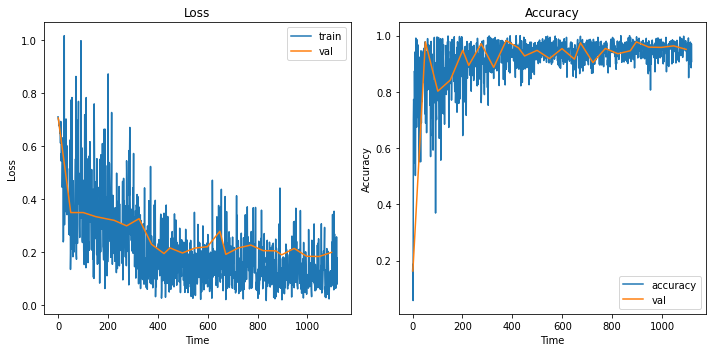

In [6]:
# Your plotting code here
plt.figure(figsize=((10,5)))
a, b = zip(*validations)
plt.subplot(1,2,1)
plt.plot(losses, label="train")
plt.plot(a, b, label="val")
plt.legend()
plt.title("Loss")
plt.xlabel("Time")
plt.ylabel("Loss")

plt.subplot(1,2,2)
c, d = zip(*accuracy_val)
plt.plot(accuracy_list, label="accuracy")
plt.plot(c, d, label="val")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

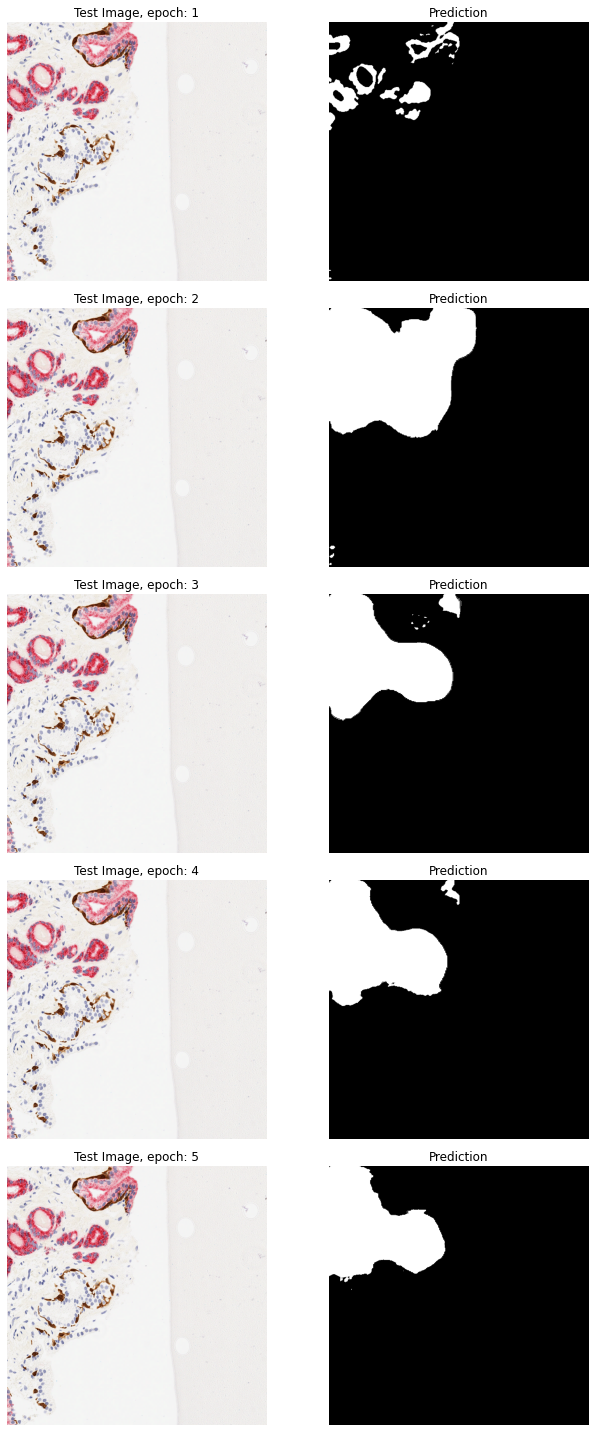

In [9]:
plt.figure(figsize=(10,20))

for i in range(len(prediction_images)):
  plt.subplot(5,2,2*i+1)
  plt.imshow(mpimg.imread("/tmp/cancer_data/cancer_data/cancer_data/inputs_test/0/pos_test_000072.png"))
  plt.title(f"Test Image, epoch: {i+1}")
  plt.axis("off")

  plt.subplot(5,2,2*i+2)
  img = prediction_images[i].squeeze(0).argmax(0).cpu().detach().numpy()
  plt.imshow(img, cmap="gray")
  plt.title("Prediction")
  plt.axis('off')

plt.tight_layout()
plt.show()